In [29]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from statsmodels.regression import linear_model

In [2]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

#### 6.1

In [3]:
# Note even though the seed is the same as in the book the randomness is not
np.random.seed(1914)
N = 200 # Num grant proposals
p = .1 # Proportion to select
# Uncorrelated newsworthiness and trustworthiness
nw = stats.norm().rvs(N)
tw = stats.norm().rvs(N)

# Select top combined scores
s = tw + nw
q = np.quantile(s, 1-p)
selected = np.where(s > q)
np.corrcoef(tw[selected], nw[selected])

array([[ 1.        , -0.64839295],
       [-0.64839295,  1.        ]])

#### 6.2

In [4]:
# Note even though the seed is the same as in the book the randomness is not
N = 100 # number of individuals
np.random.seed(909)

height = stats.norm(10, 2).rvs(N) # sim total height of each
leg_prop = stats.uniform(.4, .5).rvs(N) # leg as a proportion of height

leg_left = leg_prop*height + stats.norm(0,.02).rvs(N) # sim left leg as proportion + error
leg_right = leg_prop*height + stats.norm(0,.02).rvs(N) # sim right leg as proportion + error

d = pd.DataFrame({"height": height, "left_leg":leg_left, "leg_right":leg_right})
d.head()

,height,left_leg,leg_right
0,8.463728,6.870923,6.854695
1,9.854070,7.910084,7.821358
2,8.668694,7.160617,7.224482
3,7.523768,3.464097,3.463629
4,9.381352,5.337605,5.292569


#### 6.3

In [5]:
with pm.Model() as m_6_1:
    sigma = pm.Exponential("sigma", 1)
    br = pm.Normal("br", 2, 10)
    bl = pm.Normal("bl", 2, 10)
    a = pm.Normal("a", 10, 100)
    mu = pm.Deterministic("mu", a + bl*leg_left + br*leg_right)
    predicted_height = pm.Normal("height", mu, sigma, observed=height)
    
    trace_6_1 = pm.sample()
    
az.summary(trace_6_1, var_names=["a", "bl", "br", "sigma"])
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:44<00:00, 90.02draws/s] 


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,5.783,0.530,4.799,6.775,0.017,0.012,943.0,939.0,940.0,1089.0,1.0
bl,-7.613,4.120,-15.819,-0.357,0.162,0.115,645.0,645.0,642.0,747.0,1.0
br,8.253,4.111,1.033,16.445,0.162,0.114,646.0,646.0,644.0,741.0,1.0
sigma,1.545,0.108,1.345,1.747,0.003,0.002,1212.0,1198.0,1238.0,1334.0,1.0


#### 6.4

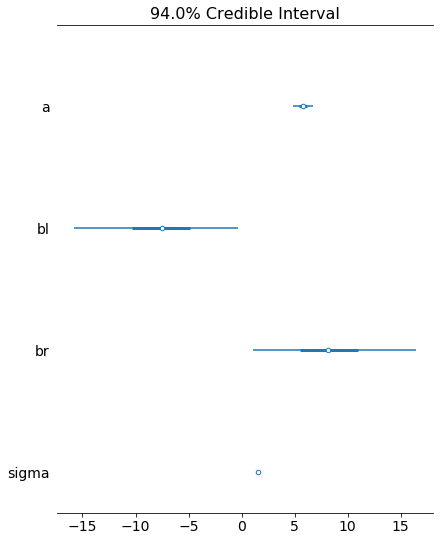

In [6]:
az.plot_forest(trace_6_1,  var_names=["a", "bl", "br", "sigma"], combined=True);

#### 6.5

100%|██████████| 2000/2000 [00:00<00:00, 27966.22it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a59e4ac10>,
      dtype=object)

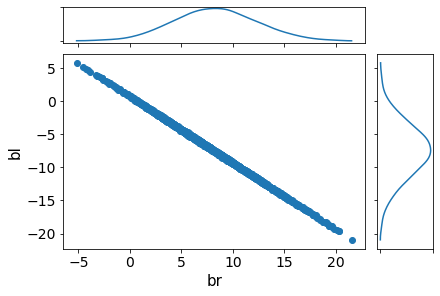

In [7]:
with m_6_1:
    posterior_predictive_6_1 = pm.sample_posterior_predictive(trace_6_1, var_names=["bl", "br"])

    # We'll use arviz density plot here for convenience
az.plot_joint({"br":posterior_predictive_6_1["br"], "bl":posterior_predictive_6_1["bl"]})

#### 6.6
Median doesn't seen to match book

Text(0.5, 0, 'sum of bl and br')

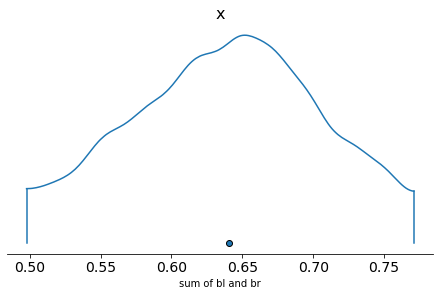

In [8]:
sum_blbr = posterior_predictive_6_1["br"] + posterior_predictive_6_1["bl"]
ax = az.plot_density(sum_blbr)
ax[0].set_xlabel("sum of bl and br")

#### 6.7

In [9]:
with pm.Model() as m_6_2:
    sigma = pm.Exponential("sigma", 1)
    bl = pm.Normal("bl", 2, 10)
    a = pm.Normal("a", 10, 100)
    mu = pm.Deterministic("mu", a + bl*leg_left)
    predicted_height = pm.Normal("height", mu, sigma, observed=height)
    
    trace_6_2 = pm.sample()
    
az.summary(trace_6_2, var_names=["a", "bl", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2447.55draws/s]
The acceptance probability does not match the target. It is 0.893187916799178, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829188721927382, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,5.677,0.570,4.658,6.805,0.022,0.016,648.0,644.0,645.0,825.0,1.00
bl,0.655,0.081,0.517,0.814,0.003,0.002,662.0,662.0,658.0,838.0,1.00
sigma,1.583,0.119,1.378,1.815,0.004,0.003,812.0,806.0,826.0,751.0,1.01


#### 6.8

In [10]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d["K"] = standardize(d["kcal.per.g"])
d["F"] = standardize(d["perc.fat"])
d["L"] = standardize(d["perc.lactose"])
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


#### 6.8

In [11]:
with pm.Model() as m_6_3:
    sigma = pm.Exponential("sigma", 1)
    bF = pm.Normal("bF", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bF*d["F"])
    k = pm.Normal("K", mu, sigma, observed=d["K"])
    
    trace_6_3 = pm.sample()
        
with pm.Model() as m_6_4:
    sigma = pm.Exponential("sigma", 1)
    bL = pm.Normal("bL", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bL*d["L"])
    k = pm.Normal("K", mu, sigma, observed=d["K"])
    
    trace_6_4 = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5082.12draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bL, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5389.11draws/s]


In [12]:
az.summary(trace_6_3, var_names=["a", "bF", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.003,0.084,-0.159,0.149,0.002,0.002,2357.0,1022.0,2375.0,1469.0,1.0
bF,0.855,0.093,0.680,1.027,0.002,0.001,2171.0,2171.0,2158.0,1310.0,1.0
sigma,0.488,0.071,0.368,0.620,0.002,0.001,2023.0,1926.0,2127.0,1542.0,1.0


In [13]:
az.summary(trace_6_4, var_names=["a", "bL", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.003,0.073,-0.130,0.142,0.002,0.002,2156.0,759.0,2161.0,1301.0,1.0
bL,-0.900,0.075,-1.035,-0.760,0.002,0.001,2384.0,2384.0,2382.0,1475.0,1.0
sigma,0.410,0.055,0.317,0.513,0.001,0.001,2250.0,2228.0,2183.0,1373.0,1.0


#### 6.10

In [14]:
with pm.Model() as m_6_4:
    sigma = pm.Exponential("sigma", 1)
    bL = pm.Normal("bL", 0, 0.5)
    bF = pm.Normal("bF", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bL*d["L"] + bF*d["F"])
    k = pm.Normal("K", mu, sigma, observed=d["K"])
    
    trace_6_5 = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3016.80draws/s]
The acceptance probability does not match the target. It is 0.8811619106787664, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795050768789507, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800246670561849, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
az.summary(trace_6_5, var_names=["a", "bF", "bL", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.070,-0.123,0.133,0.002,0.002,1275.0,1027.0,1290.0,1318.0,1.01
bF,0.259,0.202,-0.093,0.666,0.008,0.006,581.0,581.0,585.0,848.0,1.00
bL,-0.663,0.204,-1.044,-0.297,0.008,0.006,606.0,606.0,611.0,922.0,1.01
sigma,0.413,0.057,0.315,0.519,0.002,0.001,1125.0,1125.0,1087.0,1050.0,1.00


#### 6.11

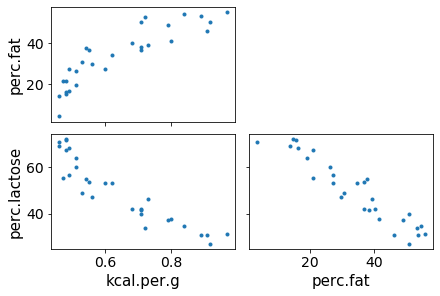

In [20]:
az.plot_pair(d[['kcal.per.g','perc.fat','perc.lactose']].to_dict(orient="list"));

#### 6.12

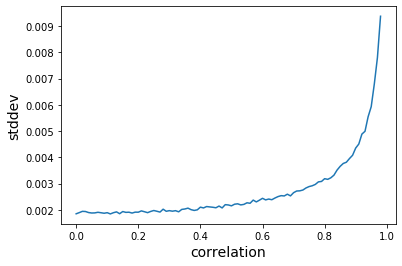

In [30]:
def simcoll(r = 0.9):
    d['x'] = stats.norm.rvs(size=len(d), loc = r * d['perc.fat'],
                       scale = np.sqrt((1 - r**2) * d['perc.fat'].var()))
    X = np.column_stack((d['perc.fat'], d['x']))
    m = linear_model.OLS(d['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### 6.13

In [45]:
np.random.seed(71)
# Number of plans

N = 100

# Simuate initial heights
h0 = stats.norm(10,2).rvs(N)

# assign treatments and simulate fungus and growth
treatment = np.tile([0,1], int(N/2))
fungus = stats.binom(n=1, p= (.5 - treatment*.4)).rvs(N)
h1 = h0 + stats.norm(5-3*fungus).rvs(N)

# compose a clean data frame
d = {"h0":h0, "h1":h1, "treatment":treatment, "fungus":fungus}
az.summary(d, kind="stats")

,mean,sd,hpd_3%,hpd_97%
h0,10.152,1.667,7.088,13.146
h1,14.523,2.299,10.138,18.535
treatment,0.500,0.503,0.000,1.000
fungus,0.270,0.446,0.000,1.000


#### 6.14
Figure out how to compute the lognormal of things

In [52]:
sim_p = stats.lognorm(x=0, s=.25).rvs(10000)
az.summary(sim_p, kind="stats")

TypeError: _parse_args() got an unexpected keyword argument 'x'

#### 6.15

In [61]:
with pm.Model() as m6_6:
    sigma = pm.Exponential("sigma", 1)
    p = pm.Lognormal("p", 0, .25)
    mu = h0*p
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed = d["h1"])
    
    trace_m6_6 = pm.sample()
az.summary(trace_m6_6, var_names=["p", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4934.32draws/s]
The acceptance probability does not match the target. It is 0.8792763931109424, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8864464950023235, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.417,0.018,1.382,1.447,0.000,0.000,1806.0,1806.0,1808.0,1439.0,1.0
sigma,1.847,0.129,1.620,2.102,0.003,0.002,1737.0,1710.0,1767.0,1292.0,1.0


#### 6.16

In [68]:
with pm.Model() as m6_7:
    
    sigma = pm.Exponential("sigma", 1)
    Βt= pm.Normal("Βt", 0, .5)
    Βf = pm.Normal("Βf", 0, .5)
    a = pm.Lognormal("a", 0, .5)
    p = a + Βt*d["treatment"] + Βf*d["fungus"]
    mu = h0*p
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed = d["h1"])
    
    trace_m6_7= pm.sample()
az.summary(trace_m6_7, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, Βf, Βt, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3197.00draws/s]
The acceptance probability does not match the target. It is 0.8786995713678436, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%
Βt,0.006,0.029,-0.047,0.057
Βf,-0.285,0.031,-0.347,-0.229
sigma,1.284,0.099,1.099,1.455
a,1.495,0.023,1.454,1.538
